# Capstone Project - Battle of Neighborhoods - City of Madrid (Spain)
Applied Data Science Capstone final project. Analyzing Madrid's trending venues

## Table of Contents


1. [Analytic Approach](#1)

2. [Data Requirements](#2)

3. [Exploring The Dataset](#3)

4. [Exploring Neighborhoods in Madrid City](#4)
   
5. [Analyze Each Neighborhood](#5)

6. [Cluster Neighborhoods](#6)

7. [Examine Clusters](#7)

8. [Conclusion](#8)


## Analytic Approach <a class="anchor" id="1"></a>
Madrid (Spain) is one of the largest cities in Europe with a metropolitan area population of approximately 6.64 million and the municipality covers 604.3 squared kilometers. The city is divided into 21 districts and 132 neighboorhoods in total. 

For this project, we should be able to answer the following question: If someone is looking to open a restaurant in the city, where would we recommend that they could open it? 

Being the city of Madrid such a crowded city leads the owners of shops to want places in the city where the population is dense. When the investors think about it, we expect from them to prefer the districts where there is a lower business cost and that there were not so many restaurants in the area of the type that they want to implant.

In order to answer that question, in order to solve the problem posed, the appropriate approach would be to group the city marking trends and analyze each group with statistical data.


## Data Requirements <a class="anchor" id="2"></a>
For this project, we will use information provided by Wikipedia in order to retrieve the boroughs and geographical coordinates of each neighboorhood of Madrid. An example of the dataset would be:
<table>
    <tr>
    <th>Borough</th>
    <th>Neighborhood</th>
    <th>Latitude</th>
    <th>Longitude</th>
  </tr>
  <tr>
    <td>Centro</td>
    <td>Palacio</td>
    <td>40.415</td>
    <td>-3.713333</td>
  </tr>
  <tr>
    <td>Centro</td>
    <td>Embajadores</td>
    <td>40.408889</td>
    <td>-3.699722</td>
  </tr>
   <tr>
    <td>Centro</td>
    <td>Cortes</td>
    <td>40.414167</td>
    <td>-3.698056</td>
  </tr>
   <tr>
    <td>Centro</td>
    <td>Justicia</td>
    <td>40.423889</td>
    <td>-3.696389</td>
  </tr>
</table>

Then, we will access the Foursquare API features to get information of the top venues in the city using the latitude and longitude of each neighborhood provided by the dataset, and finally we will do a clustering to find some common patterns and displaying them into a map. 

Also, we'll use statistical information about the venues per borough, and using folium and mapplotlib (both map and graph rendering libraries) to plot the maps for making the information more readable. 

#### Link Wikipedia:
https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid

## Exploring The Dataset <a class="anchor" id="3"></a>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

#### Load and explore the data

In [2]:
dataset = pd.read_csv("https://aws-logs-535504918282-us-east-1.s3.amazonaws.com/datasets/madrid.csv", sep=';')

In [3]:
# Exploring the first 20 rows of the dataset
dataset.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,Centro,Palacio,40.415000,-3.713333
1,Centro,Embajadores,40.408889,-3.699722
2,Centro,Cortes,40.414167,-3.698056
3,Centro,Justicia,40.423889,-3.696389
4,Centro,Universidad,40.425278,-3.708333
5,Centro,Sol,40.416667,-3.703889
6,Arganzuela,Imperial,40.406667,-3.716944
7,Arganzuela,Acacias,40.401422,-3.704936
8,Arganzuela,Chopera,40.395000,-3.699444
9,Arganzuela,Legazpi,40.388611,-3.695178


Making sure that the dataset has all 21 boroughs and 131 neighborhoods

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
            len(dataset['Borough'].unique()),
            dataset.shape[0]
        )
)

The dataframe has 21 boroughs and 131 neighborhoods.


Using <b>geopy</b> library to get the latitude and longitude values of Madrid City

In [5]:
address = 'Madrid, ES'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Madrid City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid City are 40.4167047, -3.7035825.


#### Creating a map of Madrid with neighborhoods superimposed on top.

Using <b>Folium</b> visualization library

In [6]:
# Creating a map of Madrid using latitude and longitude values taken from the dataframe 'dataset'
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# Adding markers to map
for borough, neighborhood, lat, lng in zip ( dataset['Borough']
                                           , dataset['Neighborhood']
                                           , dataset['Latitude']
                                           , dataset['Longitude']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

Next, we are going to start utilizing the <b>Foursquare API</b> to explore the neighborhoods and segment them

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'DHAVRZ3NBRLYB5X0Y4TCWIYZV324V0LI3CGPZIEUOUWASPF2' # Foursquare ID
CLIENT_SECRET = 'BO35X05P0ZBQJUNTSQYYNRLZIGO10IGQTVLWZGQHN4QRIMDP' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DHAVRZ3NBRLYB5X0Y4TCWIYZV324V0LI3CGPZIEUOUWASPF2
CLIENT_SECRET:BO35X05P0ZBQJUNTSQYYNRLZIGO10IGQTVLWZGQHN4QRIMDP


#### Exploring the neighborhood called <b>Sol</b> in the dataframe.

In [8]:
dataset_sol = dataset[dataset['Neighborhood'] == 'Sol']
dataset_sol.reset_index(inplace = True, drop = True)
dataset_sol

,Borough,Neighborhood,Latitude,Longitude
0,Centro,Sol,40.416667,-3.703889


Get the neighborhood's latitude and longitude values.

In [9]:
neighborhood_latitude = dataset_sol.loc[0 ,'Latitude'] # neighborhood latitude value
neighborhood_longitude = dataset_sol.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dataset_sol.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Sol are 40.416667, -3.7038889999999998.


#### Let's get the top 100 venues that are in <b>Sol</b> within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [10]:
# limit of number of venues returned by Foursquare API
LIMIT = 100 

# Define radius
radius = 500 

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# display URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=DHAVRZ3NBRLYB5X0Y4TCWIYZV324V0LI3CGPZIEUOUWASPF2&client_secret=BO35X05P0ZBQJUNTSQYYNRLZIGO10IGQTVLWZGQHN4QRIMDP&v=20180605&ll=40.416667,-3.7038889999999998&radius=500&limit=100'

Sending the GET request and examinating the results

In [11]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eba9ed45fb726001b44417b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 86,
  'suggestedBounds': {'ne': {'lat': 40.4211670045, 'lng': -3.697989474152486},
   'sw': {'lat': 40.412166995499994, 'lng': -3.7097885258475136}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a5201f3c21e3',
       'name': 'Puerta del Sol',
       'location': {'address': 'Pl. Puerta del Sol',
        'lat': 40.4170267569777,
        'lng': -3.703442763596807,
        'distance': 55,
        'postalCode': '28013',
        'cc': 'ES',
        'city

#### Let´s define a function that extracts the category of the venue

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to convert the json  into a <b>*pandas*</b> dataframe.

In [13]:
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Puerta del Sol,Plaza,40.417027,-3.703443
1,Rosi La Loca,Tapas Restaurant,40.415821,-3.702955
2,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709
3,Club del Gourmet Corte Ingles,Gourmet Shop,40.417497,-3.704686
4,TOC Hostel,Hostel,40.417264,-3.705928


How many venues were returned by Foursquare?

In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

86 venues were returned by Foursquare.


## Exploring Neighborhoods in Madrid City <a class="anchor" id="4"></a>

#### Let's create a function to repeat the same process to all the neighborhoods of the a given Borough of madrid

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let´s get a dataframe selecting some of Madrid center boroughs.

In [16]:
madrid_center_boroughs = ['Centro','Retiro','Chamberi','Salamanca']
madrid_center = dataset[dataset.Borough.isin(madrid_center_boroughs)]
madrid_center

,Borough,Neighborhood,Latitude,Longitude
0,Centro,Palacio,40.415000,-3.713333
1,Centro,Embajadores,40.408889,-3.699722
2,Centro,Cortes,40.414167,-3.698056
3,Centro,Justicia,40.423889,-3.696389
4,Centro,Universidad,40.425278,-3.708333
5,Centro,Sol,40.416667,-3.703889
13,Retiro,Pacífico,40.404722,-3.675833
14,Retiro,Adelfas,40.400278,-3.670833
15,Retiro,Estrella,40.413611,-3.664167
16,Retiro,Ibiza,40.418889,-3.674167


#### Running the above function on each neighborhood of that borough and create a new dataframe.

In [17]:
# limit of number of venues returned by Foursquare API
LIMIT = 100
madrid_center_venues = getNearbyVenues(
                    names=madrid_center['Neighborhood'],
                    latitudes=madrid_center['Latitude'],
                    longitudes=madrid_center['Longitude']
                )

Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Pacífico
Adelfas
Estrella
Ibiza
Jeronimos
Nino Jesus
Recoletos 
Goya
Fuente del Berro
Guindalera
Lista
Castellana
Gaztambide
Arapiles
Trafalgar
Almagro
Rios Rosas
Vallehermoso


#### Let's check the size of the resulting dataframe

In [18]:
print(madrid_center_venues.shape)
madrid_center_venues.head()

(1763, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.415,-3.713333,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
1,Palacio,40.415,-3.713333,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
2,Palacio,40.415,-3.713333,Plaza de La Almudena,40.416320,-3.713777,Plaza
3,Palacio,40.415,-3.713333,Mercado Jamón Iberico,40.415442,-3.711643,Market
4,Palacio,40.415,-3.713333,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant


#### Counting the number of venues by Neighborhood

In [19]:
df_grouped = madrid_center_venues.groupby('Neighborhood').count()
df_grouped['Venue']

Neighborhood
Adelfas              32
Almagro              63
Arapiles             75
Castellana          100
Cortes              100
Embajadores          69
Estrella             29
Fuente del Berro     32
Gaztambide          100
Goya                 99
Guindalera           65
Ibiza                43
Jeronimos           100
Justicia            100
Lista                72
Nino Jesus           27
Pacífico             71
Palacio             100
Recoletos           100
Rios Rosas           54
Sol                  86
Trafalgar           100
Universidad          87
Vallehermoso         59
Name: Venue, dtype: int64

#### How many unique categories can be curated from all the returned venues?

In [20]:
print('There are {} uniques categories.'.format(len(madrid_center_venues['Venue Category'].unique())))

There are 205 uniques categories.


#### Now let´s visualize the number of venues grouped by neighborhood using a *bar chart*. A *bar plot* is a way of representing data where the length of the bars represents the magnitude or size of the feature or variable.

Getting the grouped and sorted dataframe by venue

In [21]:
df_grouped_venues = df_grouped['Venue'].to_frame()
df_grouped_venues.sort_values(by='Venue', ascending=True, inplace=True)
df_grouped_venues

,Venue
Neighborhood,
Nino Jesus,27
Estrella,29
Adelfas,32
Fuente del Berro,32
Ibiza,43
Rios Rosas,54
Vallehermoso,59
Almagro,63
Guindalera,65


View the bar chart

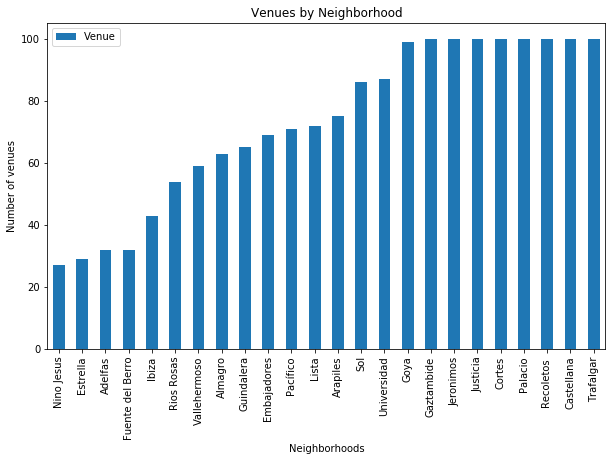

In [22]:
# Plot data
df_grouped_venues.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Venues by Neighborhood') # add title to the plot

plt.show()

It can be seen that those neighborhoods with 100 returned venues correspond to the most central ones

## Analyze Each Neighborhood <a class="anchor" id="5"></a>

**Indicator variable (or dummy variable)**

What is an *indicator variable*? 
<p>
An indicator variable (or dummy variable) is a numerical variable used to label categories. They are called 'dummies' because the numbers themselves don't have inherent meaning. 
</p>

We will use the panda's method *get_dummies* to assign numerical values to different categories of *Venue Category* from the *madrid_center_venues* dataframe. 


In [23]:
# One hot encoding: get indicator variables and assign it to a new dataframe
madrid_onehot = pd.get_dummies(madrid_center_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_center_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Burger Joint,Burrito Place,Café,Camera Store,Casino,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Palacio,0,0,0,

And let's examine the new dataframe size.

In [24]:
madrid_onehot.shape

(1763, 205)

#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Burger Joint,Burrito Place,Café,Camera Store,Casino,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store
0,Adelfas,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.031250,0.000000,0.000000,0.031250,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.031250,0.000000,0.031250,0.000000,0.062500,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.093750,0.00,0.031250,0.00,0.03125,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.062500,0.031250,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.00,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.031250,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,

#### And the new size is:

In [26]:
madrid_grouped.shape

(24, 205)

#### Let's print each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in madrid_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelfas----
                  venue  freq
0  Fast Food Restaurant  0.09
1                 Hotel  0.06
2         Grocery Store  0.06
3    Spanish Restaurant  0.06
4                  Café  0.06


----Almagro----
                venue  freq
0          Restaurant  0.14
1  Spanish Restaurant  0.10
2                 Bar  0.05
3               Plaza  0.05
4  Italian Restaurant  0.05


----Arapiles----
                venue  freq
0  Spanish Restaurant  0.12
1                 Bar  0.08
2              Bakery  0.07
3    Tapas Restaurant  0.05
4                Café  0.05


----Castellana----
                      venue  freq
0        Spanish Restaurant  0.16
1                Restaurant  0.10
2                  Boutique  0.08
3               Coffee Shop  0.06
4  Mediterranean Restaurant  0.04


----Cortes----
              venue  freq
0              Café  0.07
1               Bar  0.07
2             Hotel  0.07
3        Restaurant  0.06
4  Tapas Restaurant  0.05


----Embajadores----
           

#### Let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelfas,Fast Food Restaurant,Hotel,Café,Bar,Supermarket,Spanish Restaurant,Grocery Store,Football Stadium,Food & Drink Shop,Gift Shop
1,Almagro,Restaurant,Spanish Restaurant,Italian Restaurant,Plaza,Bar,Breakfast Spot,Salad Place,Pub,Café,Nightclub
2,Arapiles,Spanish Restaurant,Bar,Bakery,Tapas Restaurant,Café,Restaurant,Hotel,Burrito Place,Multiplex,Theater
3,Castellana,Spanish Restaurant,Restaurant,Boutique,Coffee Shop,Mediterranean Restaurant,Tapas Restaurant,Gym / Fitness Center,Japanese Restaurant,Bar,Hotel
4,Cortes,Hotel,Café,Bar,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Plaza,Theater,Seafood Restaurant,Jazz Club


## Cluster Neighborhoods <a class="anchor" id="6"></a>

#### We have some common venue categories in each neighborhood. 
#### We will use  an unsupervised *machine learning* **K-means** algorithm to cluster the neighborhoods. 

Lets Run *k*-means to cluster the neighborhoods into 5 clusters.

In [30]:
# set number of clusters
kclusters = 5

madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 1, 0, 1, 3, 3, 4, 4, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = madrid_center

# merge madrid_grouped with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# check the last columns!
madrid_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Palacio,40.415000,-3.713333,0,Tapas Restaurant,Spanish Restaurant,Plaza,Bar,Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Church,Mediterranean Restaurant,Cocktail Bar
1,Centro,Embajadores,40.408889,-3.699722,3,Bar,Café,Tapas Restaurant,Spanish Restaurant,Bookstore,Market,Plaza,Restaurant,Art Gallery,Pizza Place
2,Centro,Cortes,40.414167,-3.698056,3,Hotel,Café,Bar,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Plaza,Theater,Seafood Restaurant,Jazz Club
3,Centro,Justicia,40.423889,-3.696389,3,Restaurant,Bakery,Spanish Restaurant,Hotel,Bookstore,Vegetarian / Vegan Restaurant,Deli / Bodega,Flower Shop,Nightclub,Sandwich Place
4,Centro,Universidad,40.425278,-3.708333,3,Café,Hotel,Bookstore,Spanish Restaurant,Tapas Restaurant,Theater,Plaza,Cocktail Bar,Bar,Argentinian Restaurant
5,Centro,Sol,40.416667,-3.703889,3,Hotel,Plaza,Hostel,Restaurant,Wine Bar,Art Museum,Spanish Restaurant,Gourmet Shop,Tapas Restaurant,Peruvian Restaurant
13,Retiro,Pacífico,40.404722,-3.675833,4,Spanish Restaurant,Bar,Café,Food & Drink Shop,Pizza Place,Restaurant,Grocery Store,Art Gallery,Indian Restaurant,Brewery
14,Retiro,Adelfas,40.400278,-3.670833,4,Fast Food Restaurant,Hotel,Café,Bar,Supermarket,Spanish Restaurant,Grocery Store,Football Stadium,Food & Drink Shop,Gift Shop
15,Retiro,Estrella,40.413611,-3.664167,4,Supermarket,Spanish Restaurant,Bar,Park,Coffee Shop,Plaza,Big Box Store,Sports Club,Fast Food Restaurant,Italian Restaurant
16,Retiro,Ibiza,40.418889,-3.674167,2,Spanish Restaurant,Tapas Restaurant,Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Seafood Restaurant,Ice Cream Shop,Indian Restaurant,Gourmet Shop


Finally, let's visualize the resulting clusters

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(  madrid_merged['Latitude']
                                  , madrid_merged['Longitude']
                                  , madrid_merged['Neighborhood']
                                  , madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters <a class="anchor" id="7"></a>

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [33]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Palacio,Tapas Restaurant,Spanish Restaurant,Plaza,Bar,Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Church,Mediterranean Restaurant,Cocktail Bar
37,Gaztambide,Spanish Restaurant,Café,Bar,Tapas Restaurant,Italian Restaurant,Restaurant,Sandwich Place,Mediterranean Restaurant,Pub,Coffee Shop
38,Arapiles,Spanish Restaurant,Bar,Bakery,Tapas Restaurant,Café,Restaurant,Hotel,Burrito Place,Multiplex,Theater
39,Trafalgar,Restaurant,Spanish Restaurant,Bar,Bakery,Tapas Restaurant,Café,Plaza,Italian Restaurant,Brewery,Mediterranean Restaurant
41,Rios Rosas,Tapas Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Café,Cocktail Bar,Pizza Place,Spanish Restaurant,Bar,Post Office


#### Cluster 2

In [34]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Jeronimos,Spanish Restaurant,Hotel,Restaurant,Park,Café,Art Museum,Plaza,Garden,Mediterranean Restaurant,Italian Restaurant
19,Recoletos,Restaurant,Spanish Restaurant,Italian Restaurant,Hotel,Clothing Store,Japanese Restaurant,Coffee Shop,Accessories Store,Shoe Store,Boutique
20,Goya,Spanish Restaurant,Restaurant,Bakery,Ice Cream Shop,Tapas Restaurant,Seafood Restaurant,Burger Joint,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant
24,Castellana,Spanish Restaurant,Restaurant,Boutique,Coffee Shop,Mediterranean Restaurant,Tapas Restaurant,Gym / Fitness Center,Japanese Restaurant,Bar,Hotel
40,Almagro,Restaurant,Spanish Restaurant,Italian Restaurant,Plaza,Bar,Breakfast Spot,Salad Place,Pub,Café,Nightclub


#### Cluster 3

In [35]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Ibiza,Spanish Restaurant,Tapas Restaurant,Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Seafood Restaurant,Ice Cream Shop,Indian Restaurant,Gourmet Shop
22,Guindalera,Spanish Restaurant,Hotel,Bar,Indian Restaurant,Restaurant,Supermarket,Seafood Restaurant,Café,Japanese Restaurant,Asian Restaurant
23,Lista,Spanish Restaurant,Restaurant,Bar,Indian Restaurant,Seafood Restaurant,Hotel,Coffee Shop,Mediterranean Restaurant,Burger Joint,Grocery Store


#### Cluster 4

In [36]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Embajadores,Bar,Café,Tapas Restaurant,Spanish Restaurant,Bookstore,Market,Plaza,Restaurant,Art Gallery,Pizza Place
2,Cortes,Hotel,Café,Bar,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Plaza,Theater,Seafood Restaurant,Jazz Club
3,Justicia,Restaurant,Bakery,Spanish Restaurant,Hotel,Bookstore,Vegetarian / Vegan Restaurant,Deli / Bodega,Flower Shop,Nightclub,Sandwich Place
4,Universidad,Café,Hotel,Bookstore,Spanish Restaurant,Tapas Restaurant,Theater,Plaza,Cocktail Bar,Bar,Argentinian Restaurant
5,Sol,Hotel,Plaza,Hostel,Restaurant,Wine Bar,Art Museum,Spanish Restaurant,Gourmet Shop,Tapas Restaurant,Peruvian Restaurant


#### Cluster 5

In [37]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Pacífico,Spanish Restaurant,Bar,Café,Food & Drink Shop,Pizza Place,Restaurant,Grocery Store,Art Gallery,Indian Restaurant,Brewery
14,Adelfas,Fast Food Restaurant,Hotel,Café,Bar,Supermarket,Spanish Restaurant,Grocery Store,Football Stadium,Food & Drink Shop,Gift Shop
15,Estrella,Supermarket,Spanish Restaurant,Bar,Park,Coffee Shop,Plaza,Big Box Store,Sports Club,Fast Food Restaurant,Italian Restaurant
18,Nino Jesus,Spanish Restaurant,Grocery Store,Asian Restaurant,Supermarket,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Garden,Gym,Jazz Club
21,Fuente del Berro,Park,Tapas Restaurant,Bar,Spanish Restaurant,Grocery Store,Performing Arts Venue,Gym / Fitness Center,Convenience Store,Coffee Shop,Supermarket
42,Vallehermoso,Bar,Spanish Restaurant,Restaurant,Café,Sandwich Place,Pizza Place,Tapas Restaurant,Bakery,Grocery Store,Soccer Field


## Conclusion <a class="anchor" id="8"></a>

People are turning to big cities to start a business or work. For this reason, people can achieve better outcomes through accessing to the platforms where such information is provided.

Also city managers can manage the city much better by using similar data analysis types or platforms.